In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv, concat
from tqdm import tqdm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 1: 

In [2]:
## Load metadata.
metadata = read_csv(os.path.join('..','data','metadata.csv'))

## Initialize reject DataFrame.
reject = metadata.loc[metadata['prev-complete']=="No",['platform','subject']].copy()

## Section 2 Self-Report Metrics

In [3]:
## Load survey data.
surveys = read_csv(os.path.join('..','data','surveys.csv'))

## Restrict participants.
surveys = surveys.loc[surveys.subject.isin(reject.subject)]

## Define subscales.
subscales = [
    ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q12'],    # 7u7d Mania
    ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q13','7u7d-q14'],    # 7u7d Depression
    ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],    # GAD-7
    ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08'],
    ['bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05',
     'shaps-q06','shaps-q07','shaps-q08','shaps-q09','shaps-q10',
     'shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
    ['pswq-q01','pswq-q02','pswq-q03']
]

## Define response scales.
minlengths = [4,4,4,4,4,4,4,5]

#### 2.1 Infrequency Items
Following Huang et al. (2015) and Ophir et al. (2019), we included 4 infrequency items in our surveys. These are items with a correct or highly probable answer.

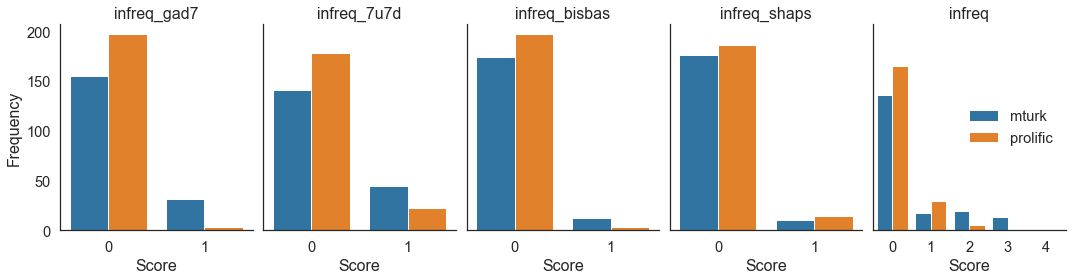

In [4]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract infrequency items.
cols = ['platform','subject','gad7-q08','7u7d-q15','bisbas-q13','shaps-q15']
infreq = surveys[cols].copy()
infreq.columns = ['platform','subject','infreq_gad7','infreq_7u7d','infreq_bisbas','infreq_shaps']

## Score infrequency items.
infreq['infreq_gad7'] = np.in1d(infreq['infreq_gad7'], (1,2,3)).astype(int)
infreq['infreq_7u7d'] = np.in1d(infreq['infreq_7u7d'], (1,2,3)).astype(int)
infreq['infreq_bisbas'] = np.in1d(infreq['infreq_bisbas'], (0,1)).astype(int)
infreq['infreq_shaps'] = np.in1d(infreq['infreq_shaps'], (0,1)).astype(int)

## Sum across items.
infreq['infreq'] = infreq.filter(regex='infreq').sum(axis=1)

## Merge with reject.
reject = reject.merge(infreq)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,5,figsize=(15,4),sharey=True)

## Iteratively plot distributions.
for i, col in enumerate(reject.filter(regex='infreq').columns):
    
    ## Plot countplot.
    sns.countplot(x=col, hue='platform', data=reject, ax=axes[i])
    axes[i].legend_.set_visible(False)
    axes[i].set(xlabel='Score', ylabel='', title=col)
    if not i: axes[i].set_ylabel('Frequency')
    if col == 'infreq': axes[i].legend(loc=7, bbox_to_anchor=(1,0.5), frameon=False)
    
sns.despine()
plt.tight_layout()

#### 2.2 Inter-item Standard Deviation

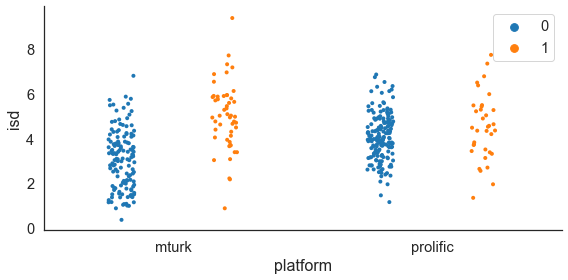

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
scores = np.zeros((len(surveys), len(subscales)))

## Iteratively compute ISD.
for i, cols in enumerate(subscales):
    
    ## Extract responses.
    X = surveys[cols].values.copy()

    ## Compute ISD.
    a = np.power(X - X.mean(axis=1)[:,np.newaxis], 2).sum(axis=1)
    b = X.shape[1] - 1
    scores[:,i] = np.sqrt(a / b)
    
## Sum across subscales.
scores = scores.sum(axis=1)

## Add to reject DataFrame.
reject['isd'] = scores

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot entropy.
sns.stripplot(x='platform', y='isd', hue=np.where(reject.infreq,1,0), data=reject, dodge=True, size=4, ax=ax)

sns.despine()
plt.tight_layout()

#### 2.3 Personal Reliability

100%|██████████| 1000/1000 [00:21<00:00, 45.91it/s]


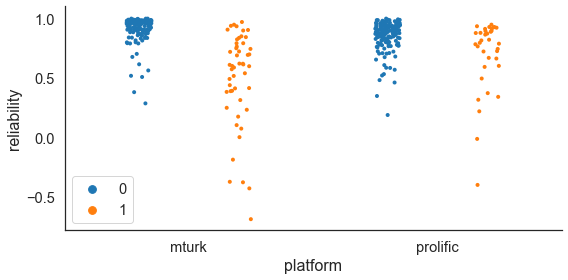

In [6]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of shuffles.
n_iter = 1000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Main loop.
scores = np.zeros((n_iter, len(surveys)), dtype=float)

for i in tqdm(range(n_iter)):
    
    ## Preallocate space.
    X = np.zeros((len(surveys), len(subscales)))
    Y = np.zeros((len(surveys), len(subscales)))
    
    ## Iteratively compute split-half scores.    
    for j, subscale in enumerate(subscales):
        
        ## Permute subscale.
        ix = np.random.permutation(subscale)
        
        ## Compute average within each half.
        X[:,j] = surveys[subscale[::2]].mean(axis=1)
        Y[:,j] = surveys[subscale[1::2]].mean(axis=1)
        
    ## Compute correlation coefficient.
    a = np.mean(X * Y, axis=1) - np.mean(X, axis=1) * np.mean(Y, axis=1)
    b = np.std(X, axis=1) * np.std(Y, axis=1)
    scores[i] = a / b
    
## Average across permutations.
scores = scores.mean(axis=0)

## Add to reject DataFrame.
reject['reliability'] = scores

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot entropy.
sns.stripplot(x='platform', y='reliability', hue=np.where(reject.infreq,1,0), data=reject, dodge=True, size=4, ax=ax)

sns.despine()
plt.tight_layout()

#### 2.4 Mahalanobis D

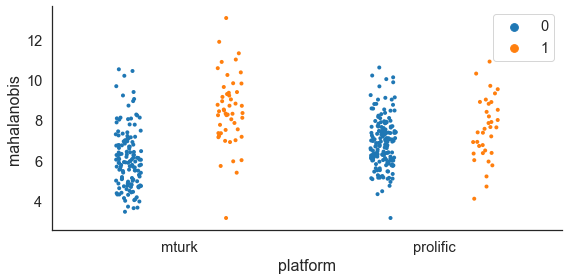

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Restrict to items of interest.
items = surveys[np.concatenate(subscales)].copy()

## Compute (inverse) covariance matrix.
Sigma = items.cov()
Sigma_inv = np.linalg.inv(Sigma)

## Preallocate space.
scores = np.zeros(items.shape[0])

## Iteratively compute Mahalanobis D.
mu = items.mean()
for i in range(items.shape[0]):
    x = items.iloc[i] - mu
    scores[i] = np.sqrt(x @ Sigma_inv @ x)
        
## Add to reject DataFrame.
reject['mahalanobis'] = scores

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot entropy.
sns.stripplot(x='platform', y='mahalanobis', hue=np.where(reject.infreq,1,0), data=reject, dodge=True, size=4, ax=ax)

sns.despine()
plt.tight_layout()

#### 2.5 Reading Time

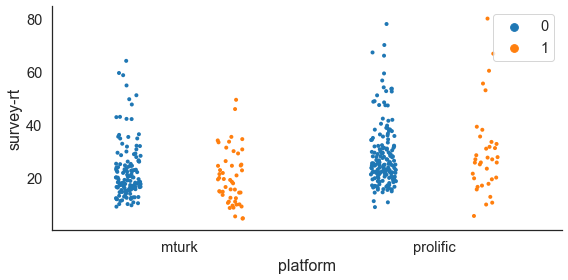

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract response times.
rt = surveys[['platform','subject','gad7-rt','7u7d-rt','bisbas-rt','shaps-rt','pswq-rt']].copy()

## Iteratively compute scores.
for prefix in ['gad7','7u7d','bisbas','shaps','pswq']:
    rt[f'{prefix}-rt'] /= surveys.filter(regex=f'{prefix}-q').columns.size

## Sum across items.
rt['survey-rt'] = rt.filter(regex='rt').sum(axis=1)

## Merge with reject.
reject = reject.merge(rt)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot entropy.
sns.stripplot(x='platform', y='survey-rt', hue=np.where(reject.infreq,1,0), data=reject, dodge=True, size=4, ax=ax)

sns.despine()
plt.tight_layout()

## Section 3: Behavioral Data

In [9]:
## Load survey data.
data = read_csv(os.path.join('..','data','data.csv'))

## Restrict participants.
data = data.loc[data.subject.isin(reject.subject)]

#### 3.1 Variability

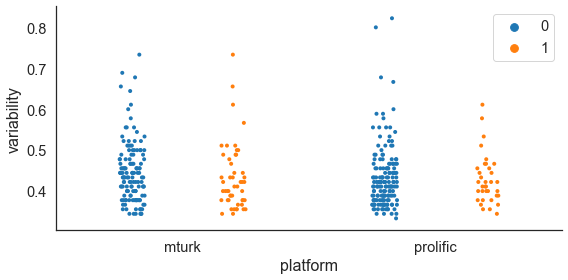

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute most chosen option within subjects.
gb = data.groupby(['platform','subject']).choice.apply(lambda x: x.value_counts().max() / x.size).reset_index()

## Rename columns.
gb = gb.rename(columns={'choice':'variability'})

## Merge with reject.
reject = reject.merge(gb)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot entropy.
sns.stripplot(x='platform', y='variability', hue=np.where(reject.infreq,1,0), data=reject, dodge=True, size=4, ax=ax)

sns.despine()
plt.tight_layout()

#### 3.2 Accuracy
```python
from scipy.stats import binom_test
binom_test(38, n=90, p=0.33, alternative='greater')
```

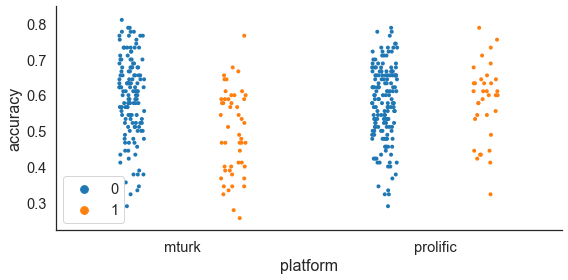

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute within-subject accuracy.
gb = data.groupby(['platform','subject']).accuracy.mean().reset_index()

## Merge with reject.
reject = reject.merge(gb)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot entropy.
sns.stripplot(x='platform', y='accuracy', hue=np.where(reject.infreq,1,0), data=reject, dodge=True, size=4, ax=ax)

sns.despine()
plt.tight_layout()

#### 3.3 Win-Stay Lose-Shift

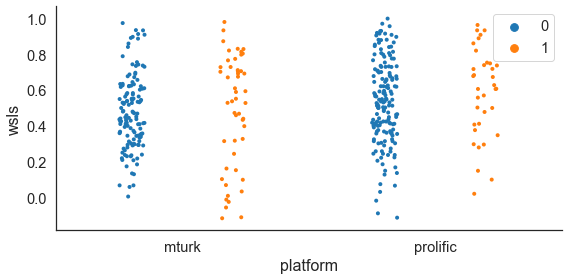

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define previous outcome.
f = lambda x: np.where(np.roll(x, 1), 0.5, -0.5)
data['prev_outcome'] = data.groupby('subject').outcome.transform(f)
data.loc[data.trial==1,'prev_outcome'] = np.nan

## Define stay choices.
f = lambda x: (x == np.roll(x,1)).astype(int)
data['stay'] = data.groupby('subject').choice.transform(f)
data.loc[data.trial==1,'stay'] = np.nan

## Define intercept.
data['intercept'] = 1

## Compute pivot table.
pivot = data.groupby(['platform','subject','prev_outcome']).stay.mean().reset_index()
pivot = pivot.pivot_table('stay',['platform','subject'],'prev_outcome').reset_index()

## Define WSLS regression.
def wsls_regression(df):
    df = df.dropna().copy()
    X = df[['intercept','prev_outcome']].dropna().values    
    y = df['stay']
    return np.linalg.lstsq(X,y,rcond=-1)[0][-1]

## Compute WSLS coefficient.
gb = data.groupby(['platform','subject']).apply(wsls_regression).reset_index()
gb = gb.rename(columns={0:'wsls'})

## Merge with reject.
reject = reject.merge(gb)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot entropy.
sns.stripplot(x='platform', y='wsls', hue=np.where(reject.infreq,1,0), data=reject, dodge=True, size=4, ax=ax)

sns.despine()
plt.tight_layout()

#### 3.4 Response Times

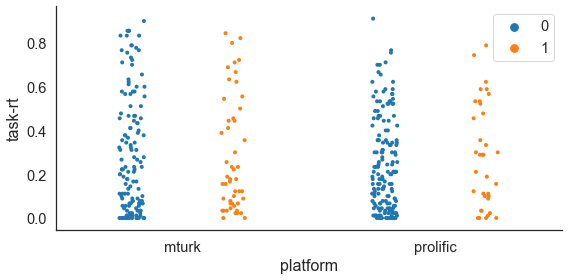

In [13]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute metrics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute within-subject response time flags.
gb = data.groupby(['platform','subject']).rt.apply(lambda x: np.mean(x < 0.2)).reset_index()
gb = gb.rename(columns={'rt':'task-rt'})

## Merge with DataFrame.
reject = reject.merge(gb)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot entropy.
sns.stripplot(x='platform', y='task-rt', hue=np.where(reject.infreq,1,0), data=reject, dodge=True, size=4, ax=ax)

sns.despine()
plt.tight_layout()

## Section 4: Metric Correspondence

In [14]:
## Define variables of interest.
cols = ['infreq','isd','reliability','mahalanobis','survey-rt','variability','accuracy','wsls','task-rt']

## Precompute lower triangular indices.
ix = np.tril_indices(len(cols), k=-1)

## Precompute space for results.
tril = np.zeros((ix[0].size, 3))
fwer = np.zeros((ix[0].size, 3))

#### 4.1 Monotonic Dependence (Unthresholded)

In [17]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,0] = reject[cols].corr(method='spearman').values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = reject[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = permuted.corr(method='spearman').values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,0] = ((np.abs(tril[:,0]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / n_iter

100%|██████████| 5000/5000 [01:05<00:00, 76.54it/s]


#### 4.2 Rejection Similarity (Thresohold = 25%) 

In [18]:
from scipy.spatial.distance import dice

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define quantile.
q = 0.25

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Threshold parameters. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Copy reject DataFrame.
thresh = reject[cols].copy()

## Threshold variables.
thresh['infreq'] = np.where( thresh['infreq'] > 0, 1, 0 )
thresh['isd'] = np.where( thresh['isd'] > thresh['isd'].quantile(1-q), 1, 0 )
thresh['reliability'] = np.where( thresh['reliability'] < thresh['reliability'].quantile(q), 1, 0 )
thresh['mahalanobis'] = np.where( thresh['mahalanobis'] > thresh['mahalanobis'].quantile(1-q), 1, 0 )
thresh['survey-rt'] = np.where( thresh['survey-rt'] < thresh['survey-rt'].quantile(q), 1, 0 )
thresh['variability'] = np.where( thresh['variability'] > thresh['variability'].quantile(1-q), 1, 0 )
thresh['accuracy'] = np.where( thresh['accuracy'] < thresh['accuracy'].quantile(q), 1, 0 )
thresh['wsls'] = np.where( thresh['wsls'] < thresh['wsls'].quantile(q), 1, 0 )
thresh['task-rt'] = np.where( thresh['task-rt'] > thresh['task-rt'].quantile(1-q), 1, 0 )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,1] = 1 - thresh[cols].corr(method=dice).values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = thresh[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = 1 - permuted.corr(method=dice).values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,1] = ((np.abs(tril[:,1]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / n_iter

100%|██████████| 5000/5000 [00:46<00:00, 107.39it/s]


#### 4.3 Rejection Similarity (Thresohold = 10%) 

In [19]:
from scipy.spatial.distance import dice

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define quantile.
q = 0.10

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Threshold parameters. 
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Copy reject DataFrame.
thresh = reject[cols].copy()

## Threshold variables.
thresh['infreq'] = np.where( thresh['infreq'] > 0, 1, 0 )
thresh['isd'] = np.where( thresh['isd'] > thresh['isd'].quantile(1-q), 1, 0 )
thresh['reliability'] = np.where( thresh['reliability'] < thresh['reliability'].quantile(q), 1, 0 )
thresh['mahalanobis'] = np.where( thresh['mahalanobis'] > thresh['mahalanobis'].quantile(1-q), 1, 0 )
thresh['survey-rt'] = np.where( thresh['survey-rt'] < thresh['survey-rt'].quantile(q), 1, 0 )
thresh['variability'] = np.where( thresh['variability'] > thresh['variability'].quantile(1-q), 1, 0 )
thresh['accuracy'] = np.where( thresh['accuracy'] < thresh['accuracy'].quantile(q), 1, 0 )
thresh['wsls'] = np.where( thresh['wsls'] < thresh['wsls'].quantile(q), 1, 0 )
thresh['task-rt'] = np.where( thresh['task-rt'] > thresh['task-rt'].quantile(1-q), 1, 0 )

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Compute and store true lower diagonal.
tril[:,2] = 1 - thresh[cols].corr(method=dice).values[ix]

## Preallocate space.
max_rho = np.zeros(n_iter)

## Main loop.
for i in tqdm(range(n_iter)):
    
    ## Permute DataFrame.
    permuted = thresh[cols].apply(np.random.permutation).copy()
    
    ## Compute correlation matrix.
    permuted = 1 - permuted.corr(method=dice).values[ix]
    
    ## Store.
    max_rho[i] = np.abs(permuted).max()
    
## Compute adjusted p-values.
fwer[:,2] = ((np.abs(tril[:,2]) <= max_rho[:,np.newaxis]).sum(axis=0) + 1) / n_iter

100%|██████████| 5000/5000 [00:50<00:00, 99.34it/s] 


#### 4.4 Plotting

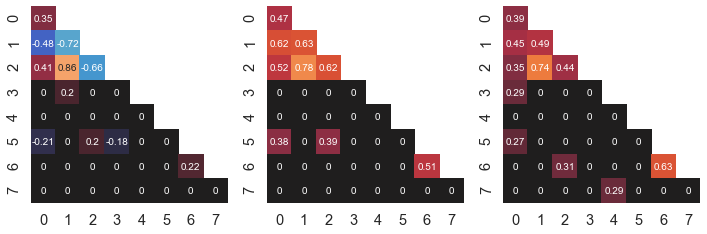

In [22]:
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i, ax in enumerate(axes):

    corr = np.zeros((len(cols),len(cols)))
    corr[ix] = np.where(fwer[:,i] < 0.05, tril[:,i], 0) 
    corr[np.triu_indices_from(corr)] = np.nan
    sns.heatmap(corr[1:,:-1], vmin=-1, vmax=1, center=0, annot=True, cbar=False, square=True, ax=ax)